In [1]:
import numpy as np
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.cuda
import time
import math
import torch as t
from numpy import cos,sin,pi,sqrt
import fun_ctions
from scipy.spatial.transform import Rotation as R
from MOT_Classes import Environment,Rubidium,particles,forward
from tqdm import tqdm\
import MOT_vars as vr

In [14]:
particles.create(T=1)

(array([[514., 452., 491., 501., 475., 483., 548., 496., 526., 514.],
        [502., 510., 455., 522., 482., 562., 485., 489., 495., 498.],
        [493., 491., 504., 491., 492., 512., 482., 518., 507., 510.]]),
 array([-4.9988303e-02, -3.9989598e-02, -2.9990897e-02, -1.9992191e-02,
        -9.9934880e-03,  5.2154064e-06,  1.0003919e-02,  2.0002622e-02,
         3.0001327e-02,  4.0000029e-02,  4.9998734e-02], dtype=float32),
 <a list of 3 BarContainer objects>)

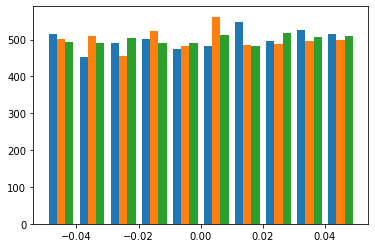

In [4]:
plt.hist(particles.x.transpose(0,1).to('cpu'))

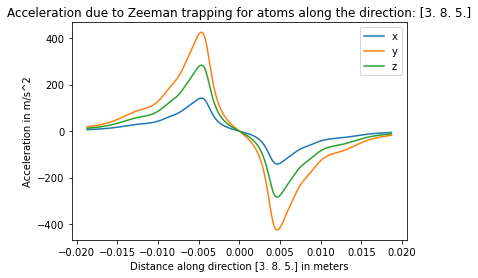

tensor(246956.9375, device='cuda:0')


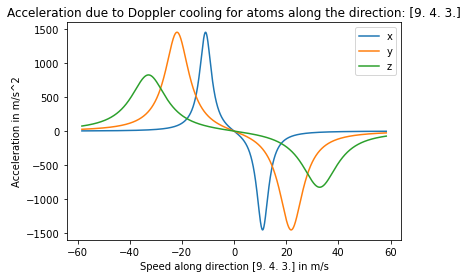

In [24]:
if False: #zeeman in x
    xsh,ysh,zsh=2000,1,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.3,0.3,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,xsh,endpoint=True),Accel[:,0,0,0].cpu().numpy())
    plt.show()
    
if False: #zeeman in y
    xsh,ysh,zsh=1,2000,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.9,xsh),t.linspace(-0.3,0.3,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,ysh,endpoint=True),Accel[0,:,0,1].cpu().numpy())
    plt.show()
    
if False: #zeeman in z
    xsh,ysh,zsh=1,1,2000
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.0,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.3,0.3,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(0)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,zsh,endpoint=True),Accel[int(xsh/2),0,:,2].cpu().numpy())
    plt.show()
      
if False: #doppler in z
    xsh,ysh,zsh=5,5,2000
    vel=t.zeros((3,xsh,ysh,zsh))
    vel[0],vel[1],vel[2]=t.meshgrid(t.linspace(-25,25,xsh),t.linspace(-25,25,ysh),t.linspace(-25,25,zsh))
    vel=vel.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    pos=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.5,0.5,zsh,endpoint=True),Accel[int(xsh/2),int(ysh/2),:,2].cpu().numpy())
    plt.show
    
if True: #zeeman along a given direction
    direction=0.005*np.array([1,3,2])
    num=5000
    d=np.linalg.norm(direction)
    pos=t.zeros((3,num))
    pos[0]=t.linspace(-direction[0],direction[0],num)
    pos[1]=t.linspace(-direction[1],direction[1],num)
    pos[2]=t.linspace(-direction[2],direction[2],num)
    pos=pos.transpose(0,1)
    vel=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Zeeman trapping for atoms along the direction: '+str(np.round(10*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Distance along direction ' +str(np.round(10*direction/d))+' in meters')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()
    print(t.max(Rates))
    
if True: #doppler along a given direction
    direction=50*np.array([1,1/2,1/3])
    d=np.linalg.norm(direction)
    num=5000
    vel=t.zeros((3,num))
    vel[0]=t.linspace(-direction[0],direction[0],num)
    vel[1]=t.linspace(-direction[1],direction[1],num)
    vel[2]=t.linspace(-direction[2],direction[2],num)
    vel=vel.transpose(0,1)
    pos=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Doppler cooling for atoms along the direction: '+str(np.round(10*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Speed along direction ' +str(np.round(10*direction/d))+' in m/s')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()


In [19]:
Simlen=vr.Sim_len 
x,v=particles.init_track(Simlen=Simlen)
for i in tqdm(range (Simlen), desc="simulating"):
    _,_  =forward(timestep=0.1,acceladj=True)
    x,v=particles.track(x,v,i)
print(v)



simulating: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]

tensor([[ -0.7601, -13.8161, -23.7647],
        [ -0.4866, -11.1604, -23.6004],
        [ -0.3194,  -3.3178, -23.4465],
        [ -0.2233,  -2.1216, -23.3211],
        [ -0.1743,  -1.5942, -23.2153],
        [ -0.1538,  -1.3728, -23.1232],
        [ -0.1477,  -1.3032, -23.0413],
        [ -0.1466,  -1.2902, -22.9669],
        [ -0.1466,  -1.2892, -22.8982],
        [ -0.1466,  -1.2891, -22.8342],
        [ -0.1466,  -1.2891, -22.7738],
        [ -0.1466,  -1.2891, -22.7164],
        [ -0.1466,  -1.2891, -22.6615],
        [ -0.1466,  -1.2891, -22.6088],
        [ -0.1466,  -1.2891, -22.5580],
        [ -0.1466,  -1.2891, -22.5087],
        [ -0.1466,  -1.2891, -22.4609],
        [ -0.1466,  -1.2891, -22.4144],
        [ -0.1466,  -1.2891, -22.3689],
        [ -0.1466,  -1.2891, -22.3245],
        [ -0.1466,  -1.2891, -22.2809],
        [ -0.1466,  -1.2891, -22.2383],
        [ -0.1466,  -1.2891, -22.1963],
        [ -0.1466,  -1.2891, -22.1551],
        [ -0.1466,  -1.2891, -22.1146],


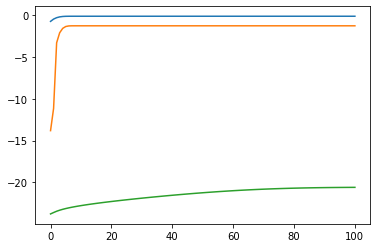

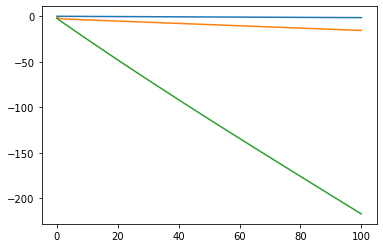

In [20]:
plt.plot(v[:,:].cpu().numpy())
plt.show()
plt.plot(x[:,:].cpu().numpy())
plt.show()